In [1]:
from cifar10 import *
import matplotlib.pyplot as plt
import numpy as np
import timeit
import datetime
import sys
from helpers import save_results
import csv
import os

#!pip install scikit-image
from skimage import transform
import skimage
import tensorflow as tf

%matplotlib inline  

## VARIABLES ##
checkpoint_path = "./more_caps/more_caps"
caps1_maps_amount = 64


In [2]:
## mean and st from train data
mean = 0.473362
std = 0.251569

test_data = load_test_data()
test_images_original = test_data[0]
test_labels_original = test_data[1]

def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input


X = tf.placeholder(shape=[None, 32, 32, 3], dtype=tf.float32, name='X')

# 32 maps of 6x6 capsules, outputs 8D activation vector
#caps1_maps_amount = 32
caps1_caps_amount = caps1_maps_amount * 8 * 8
caps1_dims = 8

# First apply two regular convolutional layers
C1 = tf.layers.conv2d(X, 
                      filters=256, 
                      kernel_size = 9, 
                      strides=1, 
                      padding='valid', 
                      activation=tf.nn.relu, 
                      name='C1')

C2 = tf.layers.conv2d(C1, 
                      filters=(caps1_maps_amount*caps1_dims), 
                      kernel_size = 9, 
                      strides=2, 
                      padding='valid', 
                      activation=tf.nn.relu, 
                      name='C2')

def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector


# Reshape to capsule
caps1_input = tf.reshape(C2, [-1, caps1_caps_amount, caps1_dims],
                       name="caps1_input")

# Calculate capsule output
caps1_output = squash(caps1_input, name='caps1_output')

# Image capsule layer
caps2_caps_amount = 10
caps2_dims = 16

init_sigma = 0.01

W_init = tf.random_normal(
    shape=(1, caps1_caps_amount, caps2_caps_amount, caps2_dims, caps1_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")


caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_caps_amount, 1, 1],
                             name="caps1_output_tiled")
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

# ## Routing by agreement
# ### Dynamic loop for routing
# Initialize routing weights to zero
raw_weights = tf.zeros([batch_size, caps1_caps_amount, caps2_caps_amount, 1, 1],
                       dtype=np.float32, name="raw_weights")

def routingNode(capsule_output, W, caps_prediction, raw_weights_initial=None):
    # X: Tiled output of a capsule layer
    # W: Current routing weights
    # caps_prediction: current prediction for the capsule layer outputs
    # raw_weights_initial: If the raw weights are already calculated, use them (First iteration)
    
    if raw_weights_initial is not None:
        raw_weights = raw_weights_initial
    
    else:
        agreement = tf.matmul(caps_prediction, capsule_output,
                          transpose_a=True, name="agreement")


        raw_weights = tf.add(W, agreement)

    routing_weights = tf.nn.softmax(raw_weights, dim=2)

    weighted_predictions = tf.multiply(routing_weights, caps_prediction)

    weighted_sum = tf.reduce_sum(weighted_predictions,
                                         axis=1, keep_dims=True)

    caps_output = squash(weighted_sum, axis=-2)
    
    return caps_output, raw_weights

# First routing node
caps2_output, raw_weights = routingNode(None, None, caps2_predicted, raw_weights)

# Loop for consequent routing nodes
total_routes = 4
for i in range(1,total_routes):
    caps2_output_tiled = tf.tile(caps2_output, [1, caps1_caps_amount, 1, 1, 1])

    caps2_output, raw_weights = routingNode(caps2_output_tiled, raw_weights, caps2_predicted)


# ## Estimating class probs

def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

y_prob = safe_norm(caps2_output, axis=-2, name="y_prob")
y_prob_argmax = tf.argmax(y_prob, axis=2, name="y_prob")
y_pred = tf.squeeze(y_prob_argmax, axis=[1,2], name="y_pred")


# ## Labels

y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

T = tf.one_hot(y, depth=caps2_caps_amount, name="T") # One hot encode labels


# ## Reconstruction as regularization
# Compute output vector for each output capsule and instance

caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")


# ## Mask
# Only send outputs to the reconstruction network from the capsule to which the image belongs

mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")


reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_caps_amount,
                                 name="reconstruction_mask")

reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_caps_amount, 1, 1],
    name="reconstruction_mask_reshaped")


caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_caps_amount * caps2_dims],
                           name="decoder_input")


# ## Decoder
# Two fully connected ReLU followed with dense output sigmoid layer

n_hidden1 = 512
n_hidden2 = 1024
n_output = 32 * 32 * 3

with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

# ## Reconstruction loss

X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")


# ## Final loss

alpha = 0.0001
loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

# ## Calculate accuracy

correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")


# ## Training ops


optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

def reset_batch(images, labels):
    # Shuffles the data
    p = np.random.permutation(len(images))
    shuffled_images = images[p]
    shuffled_labels = labels[p]
    return shuffled_images, shuffled_labels

def get_next_batch(batch_size, iteration, epoch_images, epoch_labels):
    batch_location = (iteration - 1)*batch_size
    batch_images = epoch_images[batch_location:batch_location+batch_size]
    batch_labels = epoch_labels[batch_location:batch_location+batch_size]
    
    return batch_images, batch_labels




Loading data: data/cifar-10-batches-py/test_batch


In [3]:
batch_size=100

test_images = test_images_original - mean
test_images /= std

test_labels = test_labels_original

n_iterations_test = len(test_images) // batch_size



with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    y_prob_values = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = get_next_batch(batch_size, iteration, 
                                              test_images, test_labels)
        loss_test, acc_test, y_prob_value = sess.run(
                [loss, accuracy, y_prob],
                feed_dict={X: X_batch.reshape([-1, 32, 32, 3]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        y_prob_values.append(y_prob_value)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./more_caps/more_caps
Final test accuracy: 63.9400%  Loss: 0.259299   


INFO:tensorflow:Restoring parameters from ./more_caps/more_caps


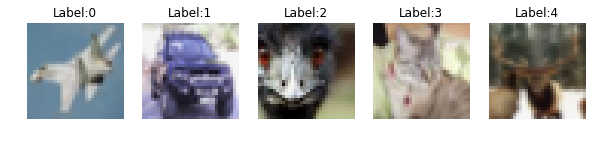

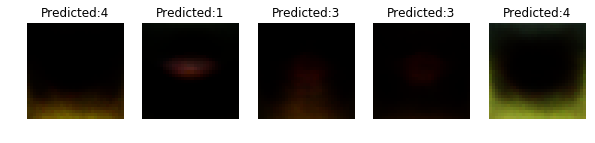

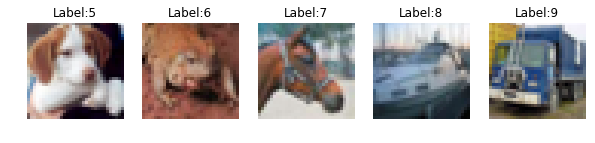

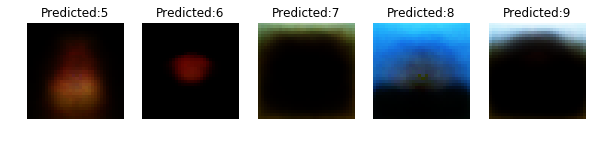

In [4]:

n_samples = 10

#idxs = np.random.randint(0,len(test_images), n_samples)
idxs = [np.where(test_labels == i)[0][1] for i in range(0,10)]
sample_images = test_images[idxs].reshape([-1, 32, 32, 3])
sample_labels = test_labels[idxs]

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

scaled_sample_images = scale_range(sample_images, 0, 1)
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(scaled_sample_images[index], cmap="binary")
    plt.title("Label:" + str(sample_labels[index]))
    plt.axis("off")
    
#plt.savefig('10_class_original1.png')
plt.show()

reconstructions = decoder_output_value.reshape([-1, 32, 32, 3])

reconstructions = scale_range(reconstructions, 0, 1)


plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")

#plt.savefig('10_class_reconstructions1.png')
plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(scaled_sample_images[index+5], cmap="binary")
    plt.title("Label:" + str(sample_labels[index+5]))
    plt.axis("off")
    
#plt.savefig('10_class_original2.png')
plt.show()

reconstructions = decoder_output_value.reshape([-1, 32, 32, 3])

reconstructions = scale_range(reconstructions, 0, 1)


plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index+5]))
    plt.imshow(reconstructions[index+5], cmap="binary")
    plt.axis("off")

#plt.savefig('10_class_reconstructions2.png')
plt.show()
